<a href="https://colab.research.google.com/github/daniel-riffi/flowsy-notebooks/blob/master/playlist_x_track_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.0MB/s 
     |████████████████████████████████| 1.1MB 58.2MB/s 
     |████████████████████████████████| 51kB 9.2MB/s 
     |████████████████████████████████| 194kB 40.7MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 40kB 6.1MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 2.6MB 63.2MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

import heapq
import math

In [4]:
base_path = '/content/gdrive/My Drive/schule/diplomarbeit/mpd'
path_models = Path('/content/gdrive/My Drive/schule/diplomarbeit/models')
mpd_csv_file = f'{base_path}/mpd_slice_0-9999.csv'
mpd_unique_tracks_file = f'{base_path}/mpd_slice_0-9999_tracks.csv'
playlists_info_file = f'{base_path}/playlists_0-9999.csv'

playlists = pd.read_csv(mpd_csv_file, delimiter=',', encoding='utf-8', header=None, low_memory=False,
                       names=['pid','track_uri','rating','playlist_name','track_name','artist_uri','artist_name'], skiprows=1)
playlists.head()

,pid,track_uri,rating,playlist_name,track_name,artist_uri,artist_name
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,1,Throwbacks,Lose Control (feat. Ciara & Fat Man Scoop),spotify:artist:2wIVse2owClT7go1WT98tk,Missy Elliott
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,1,Throwbacks,Toxic,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Britney Spears
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,1,Throwbacks,Crazy In Love,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Beyoncé
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT,1,Throwbacks,Rock Your Body,spotify:artist:31TPClRtHm23RisEBtV3X7,Justin Timberlake
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H,1,Throwbacks,It Wasn't Me,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Shaggy


In [ ]:
playlists['rating'] = playlists['rating'].apply(lambda x: x / 10)
playlists.head()

In [ ]:
dls = CollabDataLoaders.from_df(playlists, item_name='track_uri', bs=64)

In [ ]:
dls.show_batch()

,pid,track_uri,rating
0,7942,spotify:track:5ghIJDpPoe3CfHMGu71E6T,1
1,9244,spotify:track:4yuIJbzzerfKkkopLhr68D,1
2,7990,spotify:track:7Juu32WsD2Spqg8xdPuHlK,1
3,7789,spotify:track:4hNPMfFHauPIbOKvdYqFt7,1
4,1460,spotify:track:4gUDdUr5yK0JGlR49zSRVt,1
5,7343,spotify:track:1S27YnqoB8VygeNWj2yOa2,1
6,9471,spotify:track:2MRJJfu5FN6nuVuLwwdVpw,1
7,7095,spotify:track:6TaqooOXAEcijL6G1AWS2K,1
8,7486,spotify:track:0QyMDyosGai50pjaFbC1NO,1
9,225,spotify:track:5XzmZjXhMjDHr7ZfJ6DELQ,1


## Training

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0,1.5))
learn.path = path_models

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.00363078061491251)

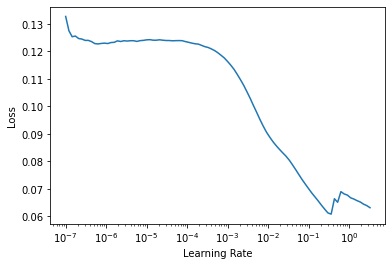

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 5e-3)

epoch,train_loss,valid_loss,time
0,0.000000,0.000000,07:50


In [ ]:
learn.export(fname='playlists_tracks_br_model_v1.pkl')

In [ ]:
learn = load_learner(path/'playlists_tracks_br_model_v1.pkl')
dls = learn.dls

## Flowsy v1

### Dot product calculation between latent factors

In [ ]:
track_factors = learn.model.i_weight.weight
playlist_factors = learn.model.u_weight.weight

track_factors.shape, playlist_factors.shape

In [ ]:
pid = 21
idx = dls.classes['pid'].o2i[pid]

In [ ]:
playlists.loc[playlists['pid'] == pid]

In [ ]:
distances = np.array(list((torch.dot(playlist_factors[idx], track_factor) for track_factor in track_factors)))

In [ ]:
#sorted = np.sort(distances)[::-1]

In [ ]:
n = 50 + playlists.loc[playlists['pid'] == pid].shape[0]

In [ ]:
#idx = np.argpartition(distances, -n)[-n:]
#indices = idx[np.argsort((-distances)[idx])]
#indices

In [ ]:
indices = heapq.nlargest(n, range(len(distances)), distances.take)

### Top tracks URI translation and filtering

In [ ]:
top_tracks_uris = list((dls.classes['track_uri'][idx] for idx in indices))

In [ ]:
tracks = pd.read_csv(mpd_unique_tracks_file, delimiter=',', encoding='utf-8', header=None,
                       names=['track_uri','track_name','artist_name'], skiprows=1)

In [ ]:
def translate_track_uris(track_uris):
    return list((tracks.loc[tracks['track_uri'] == track_uri]['track_name'].values[0] for track_uri in track_uris))

In [ ]:
tracks_of_playlist = list(playlists.loc[playlists['pid'] == pid]['track_uri'])
filtered_top_tracks = [top_track for top_track in top_tracks_uris if not top_track in tracks_of_playlist]

In [ ]:
top_tracks = translate_track_uris(filtered_top_tracks)
top_tracks[:50], len(top_tracks)

## Flowsy v2

In [ ]:
class Rating:
  def __init__(self, track_uri, track_name, artist_uri, artist_name, rating, pid):
    self.track_uri = track_uri
    self.track_name = track_name
    self.artist_uri = artist_uri
    self.artist_name = artist_name
    self.rating = rating
    self.pid = pid

  def __eq__(self, other):
    return self.track_uri == other.track_uri

  def __hash__(self):
    return hash(('track_uri', self.track_uri))

In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x)) - 0.5

In [ ]:
pid = 4039

In [ ]:
artist_counts = {}
artists = list(playlists.loc[playlists['pid'] == pid]['artist_uri'])
for artist in artists:
  artist_counts[artist] = artists.count(artist)

In [ ]:
playlist_factors = learn.model.u_weight.weight
idx = dls.classes['pid'].o2i[pid]
distances = nn.CosineSimilarity(dim=1)(playlist_factors, playlist_factors[idx][None])
idxs = distances.argsort(descending=True)[1:100]
pids = list(dls.classes['pid'][idxs])

#playlists_info.loc[playlists_info['pid'].isin(pids)]

ratings = []
count = 1
for p in pids:
  track_uris = list(playlists.loc[playlists['pid'] == p]['track_uri'])
  track_names = list(playlists.loc[playlists['pid'] == p]['track_name'])
  artist_uris = list(playlists.loc[playlists['pid'] == p]['artist_uri'])
  artist_names = list(playlists.loc[playlists['pid'] == p]['artist_name'])
  for track_uri, track_name, artist_uri, artist_name in zip(track_uris, track_names, artist_uris, artist_names):
    rating = Rating(track_uri, track_name, artist_uri, artist_name, 1 / count, pid)
    ratings.append(rating)
  count += 1

In [ ]:
for rating in ratings:
  if rating.artist_uri in artist_counts:
    rating.rating = rating.rating + sigmoid(artist_counts[rating.artist_uri])#(1 - (1 / (1 + artist_counts[rating.artist_uri])))

In [ ]:
unique_ratings = list(set(ratings))

tracks_of_playlist = list(playlists.loc[playlists['pid'] == pid]['track_uri'])
filtered_ratings = [unique_rating for unique_rating in unique_ratings if not unique_rating.track_uri in tracks_of_playlist]

filtered_ratings.sort(key=lambda x: x.rating, reverse=True)

for rating in filtered_ratings[:100]:
  print(f'{rating.artist_name} - {rating.track_name}: {rating.rating}')

Maroon 5 - She Will Be Loved - Radio Mix: 1.4933071490757153
Maroon 5 - Sunday Morning: 1.4933071490757153
Matt Nathanson - Come On Get Higher: 1.0
Chase Rice - Carolina Can: 1.0
John Mayer - Daughters: 1.0
Train - Meet Virginia: 1.0
The Fray - Over My Head (Cable Car) [Acoustic] - Live: 1.0
Five For Fighting - 100 Years: 1.0
Jason Mraz - Lucky: 1.0
Lifehouse - You And Me: 1.0
Israel Kamakawiwo'ole - Over The Rainbow: 1.0
Weezer - Island In The Sun: 1.0
Howie Day - Collide - Acoustic Version: 1.0
Glee Cast - Marry You (Glee Cast Version): 1.0
John Mayer - Waiting On the World to Change: 1.0
Train - Marry Me: 1.0
Ed Sheeran - ...Baby One More Time - Recorded at Spotify Studios NYC: 1.0
Ingrid Michaelson - You and I: 1.0
The Goo Goo Dolls - Iris: 1.0
The Goo Goo Dolls - Acoustic #3: 1.0
Jack Johnson - Better Together: 1.0
Counting Crows - Big Yellow Taxi: 1.0
Train - Calling All Angels: 1.0
Amy Winehouse - Valerie - Live At BBC Radio 1 Live Lounge, London / 2007: 1.0
James Taylor - Carol

## Analysis

In [ ]:
playlists_info = pd.read_csv(playlists_info_file, delimiter=',', encoding='utf-8', header=None,
                       names=['pid','name','num_tracks','num_albums','num_followers','num_artists','duration_ms'], skiprows=1)
playlists_info.head()

In [ ]:
def translate_playlist_pid(pids):
  return list((playlists_info.loc[playlists_info['pid'] == pid]['name'].iloc[0]) for pid in pids)

### Plot the most common tracks

In [ ]:
g = playlists.groupby('track_uri')['rating'].count()
top_tracks = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['track_uri'].o2i[t] for t in top_tracks])
track_w = learn.model.i_weight.weight[top_idxs].cpu().detach()
track_pca = track_w.pca(3)
fac0,fac1,fac2 = track_pca.t()
idxs = list(range(30))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(translate_track_uris(top_tracks[idxs]), X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

### Plot the first n playlists

In [ ]:
pids = list(range(0, 1000))
playlist_w = learn.model.u_weight.weight[pids].cpu().detach()
playlists_pca = playlist_w.pca(3)
fac0,fac1,fac2 = playlists_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(translate_playlist_pid(pids), X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()